In [ ]:
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append('/net/mulan/home/huiwann/spatial/SVC/')
import tifffile
from model.train import *
from model.utils import *
import torch 
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
import pandas as pd
from scipy.stats import wilcoxon
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_path = '/net/mulan/home/huiwann/spatial/SVC/' 
dataset = 'data/seqfish' 
device = 'cuda:1'

In [3]:
train_seqfish = np.load(f"{data_path}{dataset}/train_seqfish.npz") 
train_image = train_seqfish["data_ori"]
train_cell_morphology = train_seqfish["cell_morphology"]
train_nuclear_morphology = train_seqfish["nuclear_morphology"]
train_data_location = train_seqfish["location"]
train_cell_cycle_label = train_seqfish["identity_label"]
train_cell_cycle = train_seqfish["identity"]

train_dataset = SVC_Dataset(
    data_ori=train_image,
    location=train_data_location,
    cell_morphology_vec=train_cell_morphology,
    nuclear_morphology_vec=train_nuclear_morphology,
    identity_vec=train_cell_cycle_label,
)
print("number of training cells:", len(train_dataset),', number of genes:', train_image.shape[1])
cell_median_train = np.median(train_image.sum((1,2,3)))

read_dir =f'{data_path}{dataset}/gene2vec_weight_seqfish.npy'
gene_names = np.loadtxt(f'{data_path}{dataset}/gene_names.txt', dtype=str)
gene_names = gene_names.tolist()

number of training cells: 157 , number of genes: 1000


In [4]:
ckpt_dir = "/net/mulan/home/huiwann/spatial/SVC/checkpoints/"
ckpt = torch.load(ckpt_dir +'SVC_seqfish.pth', map_location=device)

new_ckpt = {k.replace('module.', ''): v for k, v in ckpt['model_state_dict'].items()}

gene2vec_weight = torch.from_numpy(np.load(read_dir)).float() ##n_gene * 200
print("shape of gene2vec_weight", gene2vec_weight.shape)

model = SVC(
    gene2vec_weight = gene2vec_weight,
    cell_identity_dim = train_cell_cycle_label.shape[1],
).to(device)

model_dict = model.state_dict()
for key in model_dict:
    model_dict[key] = new_ckpt[key]
model.load_state_dict(model_dict)


shape of gene2vec_weight torch.Size([1000, 200])


<All keys matched successfully>

In [5]:
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = False, num_workers = 4)
model.eval()
all_latent_train = []
cell_median = np.median(train_image.sum((1,2,3)))

with torch.no_grad():
    for i, (inputs_ori, cell_morphology, nuclear_morphology, location, cell_cycle) in enumerate(train_loader, 0):

        inputs_ori = inputs_ori.to(device)
        location = location.to(device).float()
        cell_cycle = cell_cycle.to(device).float()          
        cell_morphology = cell_morphology.to(device).float()
        nuclear_morphology = nuclear_morphology.to(device).float()
        
        size_factor = inputs_ori.sum((1,2,3))/cell_median             
        size_factor = size_factor.unsqueeze(1).unsqueeze(2).unsqueeze(3)             
        inputs = inputs_ori / size_factor 

        mask = torch.zeros(inputs.shape[0], inputs.shape[1], dtype=torch.bool, device=device)

        embedding, _, _ = model(inputs, mask, location, cell_morphology, nuclear_morphology, cell_cycle) # (n_cell, n_gene, 12, 12)
        all_latent_train.append(embedding)

all_latent_train = torch.cat(all_latent_train, dim=0)
latent_np = all_latent_train.cpu().numpy()
np.save("/net/mulan/home/huiwann/spatial/SVC/output/seqfish/embeddings_train.npy", latent_np)

### gene co-localization analysis for well-annotated genes

In [6]:
# seqfish+ genes in extended data fig 3
protrusionList = ['Cyb5r3', 'Sh3pxd2a', 'Ddr2', 'Kif1c', 'Kctd10', 
                    'Dynll2', 'Arhgap11a', 'Dync1li2', 'Palld', 'Naa50']

nuclearList = ['Col1a1', 'Fn1', 'Fbln2', 'Col6a2', 'Bgn',  
                 'Nid1', 'Lox', 'P4hb', 'Aebp1', 'Emp1',
                 'Col5a1', 'Sdc4', 'Postn', 'Col3a1', 'Pdia6',
                 'Col5a2', 'Itgb1', 'Calu', 'Pdia3']
                 
cytoplasmList = ['Ddb1', 'Myh9', 'Actn1', 'Tagln2', 'Kpnb1',
                   'Hnrnpf', 'Ppp1ca', 'Hnrnpl', 'Pcbp1', 'Tagln', 
                   'Fscn1', 'Psat1', 'Cald1', 'Snd1', 'Uba1',
                   'Hnrnpm', 'Cap1', 'Ssrp1', 'Ugdh', 'Caprin1']

nuclearSub1List = ['Thbs1', 'Serpine1', 'Ptx3', 'Tnc']
nuclearSub2List = ['Flna', 'Flnb', 'Plec', 'Flnc', 'Iqgap1']
nuclearSub3List = ['Numa1', 'Gorasp2']
print(len(nuclearList),len(cytoplasmList),len(protrusionList))

19 20 10


In [7]:
from scipy.spatial.distance import cdist


## define similarity map of 49 well-annotated genes
gene_interested = [gene for gene in cytoplasmList + nuclearList + protrusionList]
print("gene_interested:",len(gene_interested))
gene_idx = [gene_names.index(i)  for i in gene_interested]
gene_similarity_all = np.zeros((3, len(gene_interested), len(gene_interested)))
# Compute pairwise distances between gene embeddings for each cell


embeddings_train_cell_cycle_i = latent_np[train_cell_cycle == 'G1']
embeddings_train_cell_cycle_i_interested = embeddings_train_cell_cycle_i[:,gene_idx]
train_count_sum_G1  = train_image[train_cell_cycle == 'G1'].sum(axis=(-1,-2))
num_cells, num_genes, embedding_dim = embeddings_train_cell_cycle_i.shape
most_similar_genes_all_cells = {gene: [] for gene in gene_interested}
### calculate the count of cells which consider gene A as the 10 nearest neighbors in embedding space of gene B
gene_similarity = np.zeros((len(gene_interested), len(gene_interested)))

for cell in tqdm(range(num_cells)):
    gene_similarity_i = np.zeros((len(gene_interested), len(gene_interested)))
    distances = cdist(embeddings_train_cell_cycle_i_interested[cell], embeddings_train_cell_cycle_i[cell], metric='cosine')
    idx = 0 
    for gene in gene_interested:
        if train_count_sum_G1[cell][gene_idx][idx]!=0:
            most_similar_genes = np.argsort(distances[idx])[1:11]  # Exclude self-distance
            for j in most_similar_genes:
                if gene_names[j] in gene_interested:
                    gene_similarity_i[gene_interested.index(gene), gene_interested.index(gene_names[j])] = 1
        idx += 1
    gene_similarity += gene_similarity_i
gene_similarity = gene_similarity/ ((train_count_sum_G1!=0).sum(axis=0)[gene_idx]).reshape(-1,1).repeat(len(gene_similarity), axis=1)
gene_similarity_sym =  np.maximum(gene_similarity, gene_similarity.T)
gene_similarity_all[0] = gene_similarity_sym

embeddings_train_cell_cycle_i = latent_np[train_cell_cycle == 'S']
embeddings_train_cell_cycle_i_interested = embeddings_train_cell_cycle_i[:,gene_idx]
train_count_sum_S  = train_image[train_cell_cycle == 'S'].sum(axis=(-1,-2))
num_cells, num_genes, embedding_dim = embeddings_train_cell_cycle_i.shape
most_similar_genes_all_cells = {gene: [] for gene in gene_interested}
### calculate the count of cells which consider gene A as the 10 nearest neighbors in embedding space of gene B
gene_similarity = np.zeros((len(gene_interested), len(gene_interested)))
for cell in tqdm(range(num_cells)):
    gene_similarity_i = np.zeros((len(gene_interested), len(gene_interested)))
    distances = cdist(embeddings_train_cell_cycle_i_interested[cell], embeddings_train_cell_cycle_i[cell], metric='cosine')
    idx = 0 
    for gene in gene_interested:
        if train_count_sum_S[cell][gene_idx][idx]!=0:
            most_similar_genes = np.argsort(distances[idx])[1:11]  # Exclude self-distance
            for j in most_similar_genes:
                if gene_names[j] in gene_interested:
                    gene_similarity_i[gene_interested.index(gene), gene_interested.index(gene_names[j])] = 1
        idx += 1
    gene_similarity += gene_similarity_i
gene_similarity = gene_similarity/ ((train_count_sum_S!=0).sum(axis=0)[gene_idx]).reshape(-1,1).repeat(len(gene_similarity), axis=1)
gene_similarity_sym =  np.maximum(gene_similarity, gene_similarity.T)
gene_similarity_all[1] = gene_similarity_sym

embeddings_train_cell_cycle_i = latent_np[train_cell_cycle == 'G2M']
embeddings_train_cell_cycle_i_interested = embeddings_train_cell_cycle_i[:,gene_idx]
train_count_sum_G2M  = train_image[train_cell_cycle == 'G2M'].sum(axis=(-1,-2))
num_cells, num_genes, embedding_dim = embeddings_train_cell_cycle_i.shape
most_similar_genes_all_cells = {gene: [] for gene in gene_interested}
### calculate the count of cells which consider gene A as the 10 nearest neighbors in embedding space of gene B
gene_similarity = np.zeros((len(gene_interested), len(gene_interested)))
for cell in tqdm(range(num_cells)):
    gene_similarity_i = np.zeros((len(gene_interested), len(gene_interested)))
    distances = cdist(embeddings_train_cell_cycle_i_interested[cell], embeddings_train_cell_cycle_i[cell], metric='cosine')
    idx = 0 
    for gene in gene_interested:
        if train_count_sum_G2M[cell][gene_idx][idx]!=0:
            most_similar_genes = np.argsort(distances[idx])[1:11]  # Exclude self-distance
            for j in most_similar_genes:
                if gene_names[j] in gene_interested:
                    gene_similarity_i[gene_interested.index(gene), gene_interested.index(gene_names[j])] = 1
        idx += 1
    gene_similarity += gene_similarity_i
gene_similarity = gene_similarity/ ((train_count_sum_G2M!=0).sum(axis=0)[gene_idx]).reshape(-1,1).repeat(len(gene_similarity), axis=1)
gene_similarity_sym =  np.maximum(gene_similarity, gene_similarity.T)
gene_similarity_all[2] = gene_similarity_sym

gene_interested: 49


  0%|          | 0/31 [00:00<?, ?it/s]

100%|██████████| 51/51 [00:00<00:00, 157.52it/s]


In [8]:
gene_similarity_all_cytoplasm = gene_similarity_all[:,:len(cytoplasmList),:len(cytoplasmList)]
gene_similarity_all_nuclear = gene_similarity_all[:,len(cytoplasmList):len(cytoplasmList)+len(nuclearList),len(cytoplasmList):len(cytoplasmList)+len(nuclearList)]
gene_similarity_all_protrusion = gene_similarity_all[:,len(cytoplasmList)+len(nuclearList):len(cytoplasmList)+len(nuclearList)+len(protrusionList),len(cytoplasmList)+len(nuclearList):len(cytoplasmList)+len(nuclearList)+len(protrusionList)]


mask = np.triu(np.ones_like(gene_similarity_all_cytoplasm[0], dtype=bool), k=1)
gene_similarity_cytoplasm_G1 = gene_similarity_all_cytoplasm[0][mask]
gene_similarity_cytoplasm_S = gene_similarity_all_cytoplasm[1][mask]
gene_similarity_cytoplasm_G2M = gene_similarity_all_cytoplasm[2][mask]

mask = np.triu(np.ones_like(gene_similarity_all_nuclear[0], dtype=bool), k=1)
gene_similarity_nuclear_G1 = gene_similarity_all_nuclear[0][mask]
gene_similarity_nuclear_S = gene_similarity_all_nuclear[1][mask]
gene_similarity_nuclear_G2M = gene_similarity_all_nuclear[2][mask]

mask = np.triu(np.ones_like(gene_similarity_all_protrusion[0], dtype=bool), k=1)
gene_similarity_protrusion_G1 = gene_similarity_all_protrusion[0][mask]
gene_similarity_protrusion_S = gene_similarity_all_protrusion[1][mask]
gene_similarity_protrusion_G2M = gene_similarity_all_protrusion[2][mask]

In [10]:
_, p_value11 = wilcoxon(gene_similarity_cytoplasm_G2M, gene_similarity_cytoplasm_G1,alternative='greater')  
print("G2M vs G1:",p_value11)
_, p_value21 = wilcoxon(gene_similarity_cytoplasm_G2M, gene_similarity_cytoplasm_S,alternative='greater')
print("G2M vs S:",p_value21)
print("\n")

_, p_value12 = wilcoxon(gene_similarity_nuclear_G1, gene_similarity_nuclear_G2M,alternative='greater')
print("G1 vs G2M:",p_value12)
_, p_value22 = wilcoxon(gene_similarity_nuclear_S, gene_similarity_nuclear_G2M,alternative='greater')
print("S vs G2M:",p_value22)
print("\n")

_, p_value13 = wilcoxon(gene_similarity_protrusion_G1, gene_similarity_protrusion_S,alternative='greater')
print("G1 vs S:",p_value13)
_, p_value23 = wilcoxon(gene_similarity_protrusion_G1, gene_similarity_protrusion_G2M,alternative='greater')
print("G1 vs G2M:",p_value23)

G2M vs G1: 3.3006367904878372e-06
G2M vs S: 0.0005831816593887695


G1 vs G2M: 0.02631250170127539
S vs G2M: 0.002880334412841378


G1 vs S: 0.0002840637424696979
G1 vs G2M: 2.5977726458286368e-05


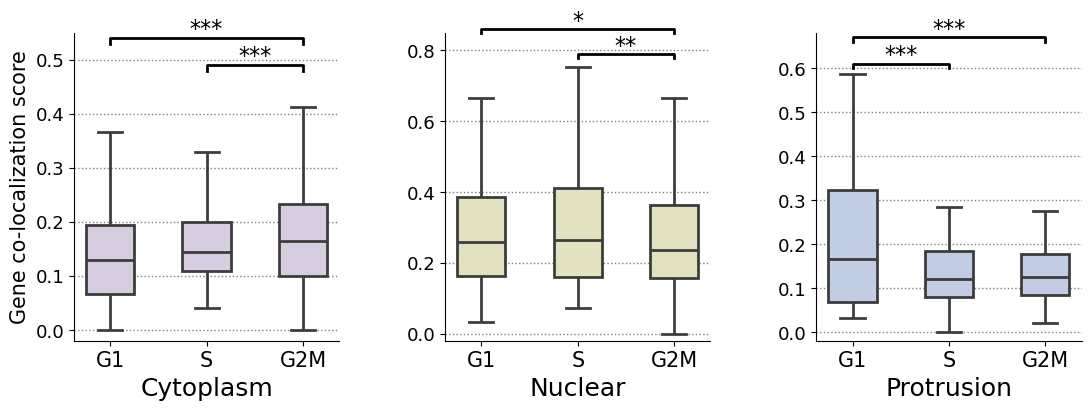

: 

In [ ]:
def get_stars(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'n.s.'  

y_offset_intra = 0.01  
y_offset_inter = 0.05 
star_offset = 0.03 
fontprops = {'size': 16, 'ha': 'center'}

fig, ax = plt.subplots(1, 3, figsize=(13, 4),   gridspec_kw={"width_ratios": [1,1,1], "wspace": 0.4})
y_max = 0.53  
sns.boxplot(data=[gene_similarity_cytoplasm_G1,gene_similarity_cytoplasm_S,gene_similarity_cytoplasm_G2M], color='#D7CAE4', width=0.5, linewidth=2, showfliers=False,ax=ax[0]) 

ax[0].set_ylabel(f'Gene co-localization score',fontsize=15)
ax[0].set_xlabel(f'Cytoplasm',fontsize=18)
ax[0].set_xticks([0, 1, 2], ['G1', 'S', 'G2M'],fontsize=15)  
ax[0].set_ylim(-0.02,0.55)
ax[0].set_yticks(np.arange(0,0.6,0.1))
ax[0].set_yticklabels(['0.0','0.1','0.2','0.3','0.4','0.5'],fontsize=13)
ax[0].grid(axis='y', color='gray', linestyle=':',linewidth=1)
ax[0].spines['top'].set_visible(False) 
ax[0].spines['right'].set_visible(False)
ax[0].plot([0,0,2,2], 
        [y_max - y_offset_inter+0.05,y_max - y_offset_inter+0.01+0.05,y_max - y_offset_inter+0.01+0.05, y_max - y_offset_inter+0.05], 
        color='black', lw=2, clip_on=False)
ax[0].text(1, y_max - y_offset_inter + 0.015+0.05, 
        get_stars(p_value11), 
        **fontprops)
ax[0].plot([1,1,2,2], 
        [y_max - y_offset_inter,y_max - y_offset_inter+0.01,y_max - y_offset_inter+0.01, y_max - y_offset_inter], 
        color='black', lw=2, clip_on=False)
ax[0].text(1.5, y_max - y_offset_inter + 0.015, 
        get_stars(p_value21), 
        **fontprops)

        
y_max = 0.83
sns.boxplot(data=[gene_similarity_nuclear_G1,gene_similarity_nuclear_S,gene_similarity_nuclear_G2M], color='#e8e7bb', width=0.5, linewidth=2, showfliers=False,ax=ax[1],zorder=10) 
ax[1].set_xlabel(f'Nuclear',fontsize=18) 
ax[1].set_xticks([0, 1, 2], ['G1', 'S', 'G2M'],fontsize=15) 
ax[1].set_ylim(-0.02,0.85)
ax[1].set_yticks(np.arange(0,0.9,0.2))
ax[1].set_yticklabels(['0.0','0.2','0.4','0.6','0.8'],fontsize=13)
ax[1].grid(axis='y', color='gray', linestyle=':',linewidth=1)
ax[1].spines['top'].set_visible(False)  
ax[1].spines['right'].set_visible(False)
ax[1].plot([0,0,2,2], 
        [y_max - y_offset_inter+0.07,y_max - y_offset_inter+0.01+0.07,y_max - y_offset_inter+0.01+0.07, y_max - y_offset_inter+0.07], 
        color='black', lw=2, clip_on=False)
ax[1].text(1, y_max - y_offset_inter + 0.015+0.07, 
        get_stars(p_value12), 
        **fontprops)
ax[1].plot([1,1,2,2], 
        [y_max - y_offset_inter,y_max - y_offset_inter+0.01,y_max - y_offset_inter+0.01, y_max - y_offset_inter], 
        color='black', lw=2, clip_on=False)
ax[1].text(1.5, y_max - y_offset_inter + 0.015, 
        get_stars(p_value22), 
        **fontprops)

y_max = 0.65 
sns.boxplot(data=[gene_similarity_protrusion_G1,gene_similarity_protrusion_S,gene_similarity_protrusion_G2M], color='#bccbe8', width=0.5, linewidth=2, showfliers=False,ax=ax[2],zorder=10) 
ax[2].set_xlabel(f'Protrusion',fontsize=18) 
ax[2].set_xticks([0, 1, 2], ['G1', 'S', 'G2M'],fontsize=15)  
ax[2].set_ylim(-0.02,0.68)
ax[2].set_yticks(np.arange(0,0.7,0.1))  
ax[2].set_yticklabels(['0.0','0.1','0.2','0.3','0.4','0.5','0.6'],fontsize=13)
ax[2].grid(axis='y', color='gray', linestyle=':',linewidth=1)
ax[2].spines['top'].set_visible(False)  
ax[2].spines['right'].set_visible(False)
ax[2].plot([0,0,1,1], 
        [y_max - y_offset_inter,y_max - y_offset_inter+0.01,y_max - y_offset_inter+0.01, y_max - y_offset_inter], 
        color='black', lw=2, clip_on=False)
ax[2].text(0.5, y_max - y_offset_inter + 0.015, 
        get_stars(p_value13), 
        **fontprops)
ax[2].plot([0,0,2,2], 
        [y_max - y_offset_inter+0.06,y_max - y_offset_inter+0.01+0.06,y_max - y_offset_inter+0.01+0.06, y_max - y_offset_inter+0.06], 
        color='black', lw=2, clip_on=False)
ax[2].text(1, y_max - y_offset_inter + 0.015+0.06, 
        get_stars(p_value23), 
        **fontprops)

plt.show()

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import to_rgba 

def create_color_cmap(source_color,target_color0, target_color=None, name='custom_cmap'):

    if target_color is None:
        colors = [
        to_rgba(source_color),       
        to_rgba(target_color0), 
    else:
        colors = [
            to_rgba(source_color),       
            to_rgba(target_color0), 
            to_rgba(target_color) 
        ]

    # 生成 Colormap
    return LinearSegmentedColormap.from_list(name, colors)

In [26]:

train_count_sum = train_image.sum(axis=(2,3))
# Compute pairwise distances between gene embeddings for each cell
num_cells, num_genes, embedding_dim = latent_np.shape
gene_interested = [gene for gene in cytoplasmList + nuclearList + protrusionList]
print("gene_interested:",len(gene_interested))
gene_idx = [gene_names.index(i)  for i in gene_interested]
latent_np_interested = latent_np[:, gene_idx]
most_similar_genes_all_cells = {gene: [] for gene in gene_interested}
### calculate the count of cells which consider gene A as the 10 nearest neighbors in embedding space of gene B
gene_similarity = np.zeros((len(gene_interested), len(gene_interested)))

for cell in tqdm(range(num_cells)):
    # Compute pairwise distances for the current cell
   
    distances = cdist(latent_np_interested[cell], latent_np[cell], metric='cosine')
    
    # Identify the most similar genes for each gene of interest in the current cell
    idx = 0 
    for gene in gene_interested:
        if train_count_sum[cell][gene_idx][idx]!=0:
            most_similar_genes = np.argsort(distances[idx])[1:11]  # Exclude self-distance
            for j in most_similar_genes:
                if gene_names[j] in gene_interested:
                    gene_similarity[gene_interested.index(gene), gene_interested.index(gene_names[j])] += 1
        idx += 1
gene_similarity = gene_similarity/ ((train_count_sum!=0).sum(axis=0)[gene_idx]).reshape(-1,1).repeat(len(gene_interested), axis=1)
gene_similarity_sym =  np.maximum(gene_similarity, gene_similarity.T)

gene_interested: 49


  0%|          | 0/157 [00:00<?, ?it/s]

100%|██████████| 157/157 [00:01<00:00, 147.96it/s]


In [13]:
print("most similar to Ddb1:",gene_interested[gene_similarity_sym[gene_interested.index('Ddb1'),:].argsort()[::-1][0]])
print("\n")
print("most similar to Col1a1:",gene_interested[gene_similarity_sym[gene_interested.index('Col1a1'),:].argsort()[::-1][0]])
print("\n")
print("most similar to Cyb5r3:",gene_interested[gene_similarity_sym[gene_interested.index('Cyb5r3'),:].argsort()[::-1][0]])

most similar to Ddb1: Myh9


most similar to Col1a1: Fn1


most similar to Cyb5r3: Sh3pxd2a


In [18]:
seqfish_data = pd.read_pickle(f"{data_path}{dataset}/seqfish_data_dict.pkl")['data_df']
print(seqfish_data.head())
df_cell_contour = pd.read_pickle(f"{data_path}{dataset}/cell_mask_contour_preprocessed.pkl")
print(df_cell_contour.head())
df_nuclear_contour = pd.read_pickle(f"{data_path}{dataset}/nuclear_mask_contour_preprocessed.pkl")
print(df_nuclear_contour.head())

             x           y           gene cell nucleus batch  umi  centerX  \
0  1217.437557  557.583252  4933401b06rik  5-0      -1     0    1     1003   
1  1096.190309  394.835294  4933401b06rik  5-0       5     0    1     1003   
2  1093.189494  572.832405  4933401b06rik  5-0      -1     0    1     1003   
3  1005.120220  297.196271  4933401b06rik  5-0      -1     0    1     1003   
4  1142.815026  378.376491  4933401b06rik  5-0      -1     0    1     1003   

   centerY        type  sc_total  
0      425  fibroblast     32224  
1      425  fibroblast     32224  
2      425  fibroblast     32224  
3      425  fibroblast     32224  
4      425  fibroblast     32224  
  cell    x    y  centerX  centerY  direction_vec  distance_to_center
0  0-0  521  496     1079      724         -158.0          602.783543
1  0-0  519  496     1079      724         -158.0          604.635427
2  0-0  517  494     1079      724         -157.5          607.242950
3  0-0  515  494     1079      724       

In [20]:
batch='0'
preserve_idx_seqfish_data =[]
for i in seqfish_data.cell:
    if i.split('-')[1] == batch:
        preserve_idx_seqfish_data.append(True)
    else:
        preserve_idx_seqfish_data.append(False)
        
preserve_idx_seqfish_data = np.array(preserve_idx_seqfish_data)

preserve_idx_cell_mask_contour =[]
for i in df_cell_contour.cell:
    if i.split('-')[1] == batch:
        preserve_idx_cell_mask_contour.append(True)
    else:
        preserve_idx_cell_mask_contour.append(False)
        
preserve_idx_cell_mask_contour = np.array(preserve_idx_cell_mask_contour)

preserve_idx_nuclear_mask_contour =[]
for i in df_nuclear_contour.cell:
    if i.split('-')[1] == batch:
        preserve_idx_nuclear_mask_contour.append(True)
    else:
        preserve_idx_nuclear_mask_contour.append(False)
        
preserve_idx_nuclear_mask_contour = np.array(preserve_idx_nuclear_mask_contour)

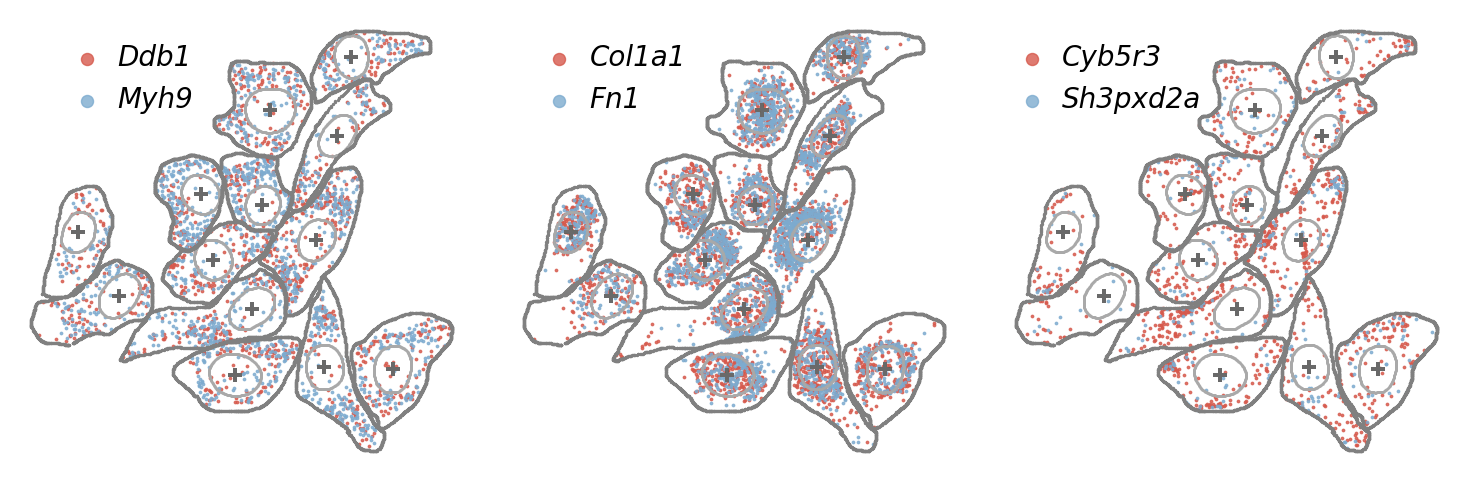

In [25]:

seqfish_data_i = seqfish_data[preserve_idx_seqfish_data]
cell_mask_contour_i= df_cell_contour[preserve_idx_cell_mask_contour]
nuclear_mask_contour_i = df_nuclear_contour[preserve_idx_nuclear_mask_contour]

fig, ax = plt.subplots(1, 3, figsize=(19, 6), gridspec_kw={'hspace': 0., 'wspace': 0.01})

gene1 ='Ddb1'
seqfish_data_i_gene1 = seqfish_data_i[seqfish_data_i.gene == gene1]

gene2 ='Myh9'
seqfish_data_i_gene2 = seqfish_data_i[seqfish_data_i.gene == gene2]

gene3 ='Col1a1'
seqfish_data_i_gene3 = seqfish_data_i[seqfish_data_i.gene == gene3]

gene4 ='Fn1'
seqfish_data_i_gene4 = seqfish_data_i[seqfish_data_i.gene == gene4]

gene5 ='Cyb5r3'
seqfish_data_i_gene5 = seqfish_data_i[seqfish_data_i.gene == gene5]

gene6 ='Sh3pxd2a'
seqfish_data_i_gene6 = seqfish_data_i[seqfish_data_i.gene == gene6]

ax[0].scatter(seqfish_data_i_gene1['x'], seqfish_data_i_gene1['y'], label=gene1, alpha=0.8, s=3,color='#d6594c')
ax[0].scatter(seqfish_data_i_gene2['x'], seqfish_data_i_gene2['y'], label=gene2, alpha=0.8, s=3,color='#7dabcf')
ax[0].scatter(nuclear_mask_contour_i['x'], nuclear_mask_contour_i['y'], alpha=0.6, s=0.5,color='darkgrey')

ax[0].scatter(cell_mask_contour_i['x'], cell_mask_contour_i['y'], color='grey', s=2)
ax[0].scatter(cell_mask_contour_i['centerX'], cell_mask_contour_i['centerY'], marker='+', color='dimgray', s=100)
ax[0].axis('off')
leg = ax[0].legend(fontsize=20,markerscale=5,bbox_to_anchor=(0.45, 0.72),frameon=False,handletextpad=0.1)
for t in leg.get_texts():     
    t.set_fontstyle('italic')
ax[0].set_aspect('equal')

ax[1].scatter(seqfish_data_i_gene3['x'], seqfish_data_i_gene3['y'], label=gene3, alpha=0.8, s=3,color='#d6594c')
ax[1].scatter(seqfish_data_i_gene4['x'], seqfish_data_i_gene4['y'], label=gene4, alpha=0.8, s=3,color='#7dabcf')
ax[1].scatter(nuclear_mask_contour_i['x'], nuclear_mask_contour_i['y'], alpha=0.6, s=0.5,color='darkgrey')
ax[1].scatter(cell_mask_contour_i['x'], cell_mask_contour_i['y'], color='grey', s=2)
ax[1].scatter(cell_mask_contour_i['centerX'], cell_mask_contour_i['centerY'], marker='+', color='dimgray', s=100)
ax[1].axis('off')
leg = ax[1].legend(fontsize=20,markerscale=5,bbox_to_anchor=(0.45, 0.72),frameon=False,handletextpad=0.1)
for t in leg.get_texts():     
    t.set_fontstyle('italic')
ax[1].set_aspect('equal')

ax[2].scatter(seqfish_data_i_gene5['x'], seqfish_data_i_gene5['y'], label=gene5, alpha=0.8, s=3,color='#d6594c')
ax[2].scatter(seqfish_data_i_gene6['x'], seqfish_data_i_gene6['y'], label=gene6, alpha=0.8, s=3,color='#7dabcf')
ax[2].scatter(nuclear_mask_contour_i['x'], nuclear_mask_contour_i['y'], alpha=0.6, s=0.5,color='darkgrey')
ax[2].scatter(cell_mask_contour_i['x'], cell_mask_contour_i['y'], color='grey', s=2)
ax[2].scatter(cell_mask_contour_i['centerX'], cell_mask_contour_i['centerY'], marker='+', color='dimgray', s=100)
leg = ax[2].legend(fontsize=20,markerscale=5,bbox_to_anchor=(0.5, 0.72),frameon=False,handletextpad=0.1)
for t in leg.get_texts():     
    t.set_fontstyle('italic')
ax[2].axis('off')
ax[2].set_aspect('equal')
plt.savefig(f'{data_path}/output/seqfish/figures/gene_colocalization_examples_batch{batch}.png', dpi=300, bbox_inches='tight',transparent=True)
plt.show()

In [16]:
top_10_gene_pair = []
upper_triangle = np.triu(gene_similarity_sym[:20,:20])
gene_interested_sub = gene_interested[:20]
for i in range(10):
    idx1,idx2 = np.where(upper_triangle == np.max(upper_triangle))
    idx1,idx2 = idx1[0],idx2[0]
    top_10_gene_pair.append((gene_interested_sub[idx1],gene_interested_sub[idx2]))
    upper_triangle[idx1,idx2] = 0
print(top_10_gene_pair)

top_10_gene_pair = []
upper_triangle = np.triu(gene_similarity_sym[20:39,20:39])
gene_interested_sub = gene_interested[20:39]
for i in range(10):
    idx1,idx2 = np.where(upper_triangle == np.max(upper_triangle))
    idx1,idx2 = idx1[0],idx2[0]
    top_10_gene_pair.append((gene_interested_sub[idx1],gene_interested_sub[idx2]))
    upper_triangle[idx1,idx2] = 0
print(top_10_gene_pair)

top_10_gene_pair = []
upper_triangle = np.triu(gene_similarity_sym[39:,39:])
gene_interested_sub = gene_interested[39:]
for i in range(10):
    idx1,idx2 = np.where(upper_triangle == np.max(upper_triangle))
    idx1,idx2 = idx1[0],idx2[0]
    top_10_gene_pair.append((gene_interested_sub[idx1],gene_interested_sub[idx2]))
    upper_triangle[idx1,idx2] = 0
print(top_10_gene_pair)


[('Ddb1', 'Myh9'), ('Tagln2', 'Ppp1ca'), ('Ddb1', 'Actn1'), ('Hnrnpf', 'Pcbp1'), ('Tagln2', 'Fscn1'), ('Ddb1', 'Tagln2'), ('Myh9', 'Actn1'), ('Myh9', 'Cald1'), ('Tagln2', 'Tagln'), ('Ddb1', 'Hnrnpl')]
[('Col1a1', 'Fn1'), ('Col1a1', 'Fbln2'), ('Fn1', 'Fbln2'), ('Fn1', 'Nid1'), ('Col1a1', 'Nid1'), ('Col1a1', 'Lox'), ('Fbln2', 'Col6a2'), ('Bgn', 'Lox'), ('Col1a1', 'Col6a2'), ('Col1a1', 'Col5a1')]
[('Cyb5r3', 'Sh3pxd2a'), ('Cyb5r3', 'Kif1c'), ('Cyb5r3', 'Ddr2'), ('Cyb5r3', 'Palld'), ('Sh3pxd2a', 'Ddr2'), ('Cyb5r3', 'Kctd10'), ('Cyb5r3', 'Arhgap11a'), ('Sh3pxd2a', 'Kif1c'), ('Cyb5r3', 'Dynll2'), ('Ddr2', 'Palld')]


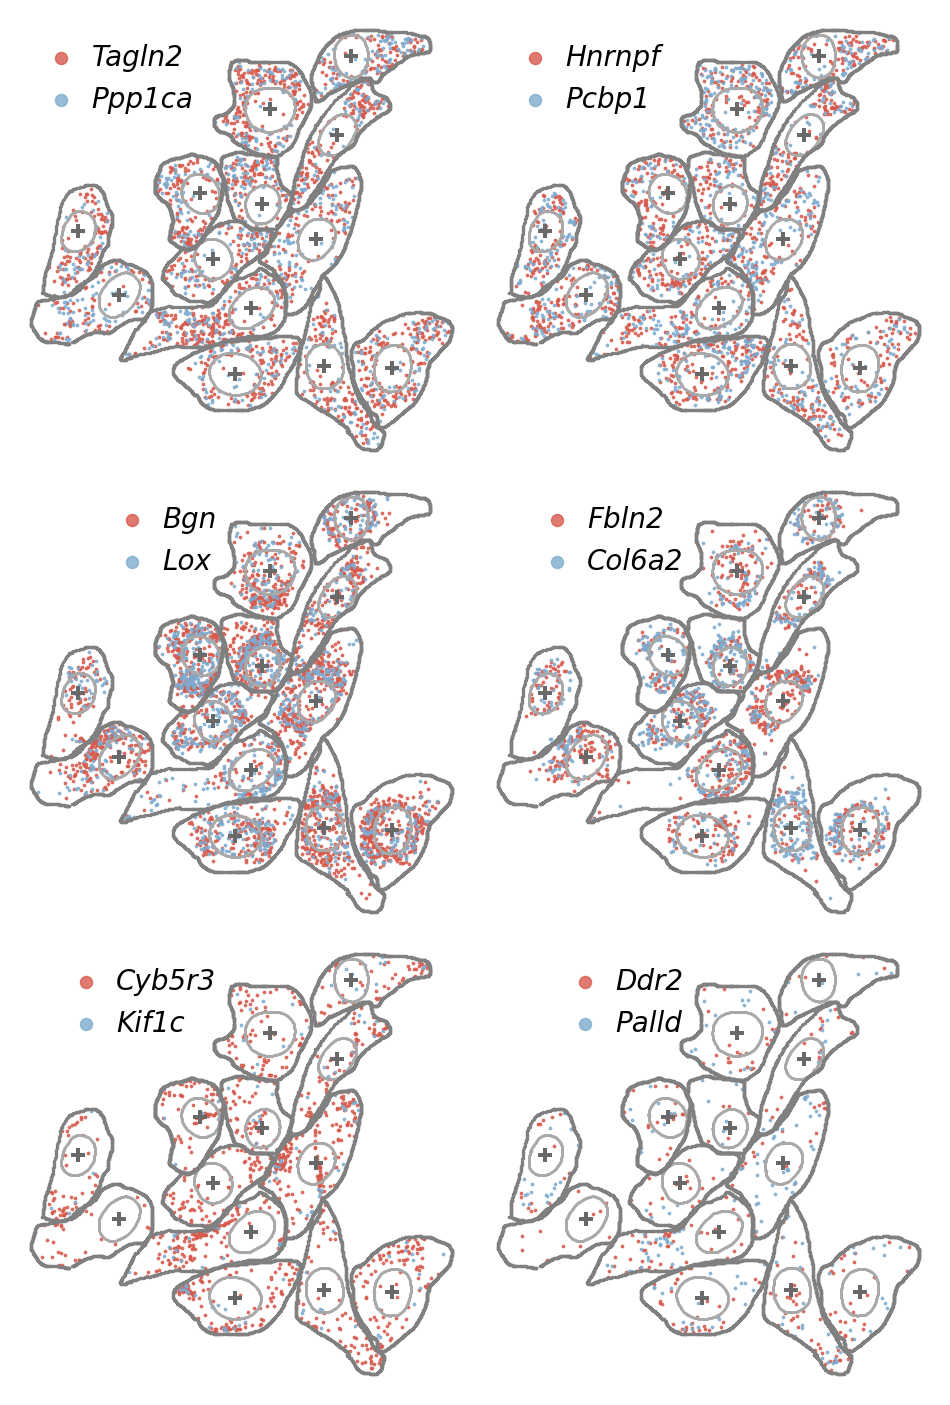

In [21]:

seqfish_data_i = seqfish_data[preserve_idx_seqfish_data]
cell_mask_contour_i= df_cell_contour[preserve_idx_cell_mask_contour]
nuclear_mask_contour_i = df_nuclear_contour[preserve_idx_nuclear_mask_contour]

fig, ax = plt.subplots(3, 2, figsize=(12, 18), gridspec_kw={'hspace': 0., 'wspace': 0.01})

gene1 ='Tagln2'
seqfish_data_i_gene1 = seqfish_data_i[seqfish_data_i.gene == gene1]

gene2 ='Ppp1ca'
seqfish_data_i_gene2 = seqfish_data_i[seqfish_data_i.gene == gene2]

gene3 ='Hnrnpf'
seqfish_data_i_gene3 = seqfish_data_i[seqfish_data_i.gene == gene3]

gene4 ='Pcbp1'
seqfish_data_i_gene4 = seqfish_data_i[seqfish_data_i.gene == gene4]

gene5 ='Bgn'
seqfish_data_i_gene5 = seqfish_data_i[seqfish_data_i.gene == gene5]

gene6 ='Lox'
seqfish_data_i_gene6 = seqfish_data_i[seqfish_data_i.gene == gene6]

gene7 ='Fbln2'
seqfish_data_i_gene7 = seqfish_data_i[seqfish_data_i.gene == gene7]

gene8 ='Col6a2'
seqfish_data_i_gene8 = seqfish_data_i[seqfish_data_i.gene == gene8]

gene9 ='Cyb5r3'
seqfish_data_i_gene9 = seqfish_data_i[seqfish_data_i.gene == gene9]

gene10 ='Kif1c'
seqfish_data_i_gene10 = seqfish_data_i[seqfish_data_i.gene == gene10]

gene11 ='Ddr2'
seqfish_data_i_gene11 = seqfish_data_i[seqfish_data_i.gene == gene11]

gene12 ='Palld'
seqfish_data_i_gene12 = seqfish_data_i[seqfish_data_i.gene == gene12]

ax[0,0].scatter(seqfish_data_i_gene1['x'], seqfish_data_i_gene1['y'], label=gene1, alpha=0.8, s=3,color='#d6594c')
ax[0,0].scatter(seqfish_data_i_gene2['x'], seqfish_data_i_gene2['y'], label=gene2, alpha=0.8, s=3,color='#7dabcf')
ax[0,0].scatter(nuclear_mask_contour_i['x'], nuclear_mask_contour_i['y'], alpha=0.6, s=0.5,color='darkgrey')

ax[0,0].scatter(cell_mask_contour_i['x'], cell_mask_contour_i['y'], color='grey', s=2)
ax[0,0].scatter(cell_mask_contour_i['centerX'], cell_mask_contour_i['centerY'], marker='+', color='dimgray', s=100)
ax[0,0].axis('off')
leg = ax[0,0].legend(fontsize=20,markerscale=5,bbox_to_anchor=(0.45, 0.72),frameon=False,handletextpad=0.1)
for t in leg.get_texts():     
    t.set_fontstyle('italic')
ax[0,0].set_aspect('equal')

ax[0,1].scatter(seqfish_data_i_gene3['x'], seqfish_data_i_gene3['y'], label=gene3, alpha=0.8, s=3,color='#d6594c')
ax[0,1].scatter(seqfish_data_i_gene4['x'], seqfish_data_i_gene4['y'], label=gene4, alpha=0.8, s=3,color='#7dabcf')
ax[0,1].scatter(nuclear_mask_contour_i['x'], nuclear_mask_contour_i['y'], alpha=0.6, s=0.5,color='darkgrey')
ax[0,1].scatter(cell_mask_contour_i['x'], cell_mask_contour_i['y'], color='grey', s=2)
ax[0,1].scatter(cell_mask_contour_i['centerX'], cell_mask_contour_i['centerY'], marker='+', color='dimgray', s=100)
ax[0,1].axis('off')
leg = ax[0,1].legend(fontsize=20,markerscale=5,bbox_to_anchor=(0.45, 0.72),frameon=False,handletextpad=0.1)
for t in leg.get_texts():     
    t.set_fontstyle('italic')
ax[0,1].set_aspect('equal')

ax[1,0].scatter(seqfish_data_i_gene5['x'], seqfish_data_i_gene5['y'], label=gene5, alpha=0.8, s=3,color='#d6594c')
ax[1,0].scatter(seqfish_data_i_gene6['x'], seqfish_data_i_gene6['y'], label=gene6, alpha=0.8, s=3,color='#7dabcf')
ax[1,0].scatter(nuclear_mask_contour_i['x'], nuclear_mask_contour_i['y'], alpha=0.6, s=0.5,color='darkgrey')
ax[1,0].scatter(cell_mask_contour_i['x'], cell_mask_contour_i['y'], color='grey', s=2)
ax[1,0].scatter(cell_mask_contour_i['centerX'], cell_mask_contour_i['centerY'], marker='+', color='dimgray', s=100)
leg = ax[1,0].legend(fontsize=20,markerscale=5,bbox_to_anchor=(0.5, 0.72),frameon=False,handletextpad=0.1)
for t in leg.get_texts():     
    t.set_fontstyle('italic')
ax[1,0].axis('off')
ax[1,0].set_aspect('equal')

ax[1,1].scatter(seqfish_data_i_gene7['x'], seqfish_data_i_gene7['y'], label=gene7, alpha=0.8, s=3,color='#d6594c')
ax[1,1].scatter(seqfish_data_i_gene8['x'], seqfish_data_i_gene8['y'], label=gene8, alpha=0.8, s=3,color='#7dabcf')
ax[1,1].scatter(nuclear_mask_contour_i['x'], nuclear_mask_contour_i['y'], alpha=0.6, s=0.5,color='darkgrey')
ax[1,1].scatter(cell_mask_contour_i['x'], cell_mask_contour_i['y'], color='grey', s=2)
ax[1,1].scatter(cell_mask_contour_i['centerX'], cell_mask_contour_i['centerY'], marker='+', color='dimgray', s=100)
leg = ax[1,1].legend(fontsize=20,markerscale=5,bbox_to_anchor=(0.5, 0.72),frameon=False,handletextpad=0.1)
for t in leg.get_texts():     
    t.set_fontstyle('italic')
ax[1,1].axis('off')
ax[1,1].set_aspect('equal')

ax[2,0].scatter(seqfish_data_i_gene9['x'], seqfish_data_i_gene9['y'], label=gene9, alpha=0.8, s=3,color='#d6594c')
ax[2,0].scatter(seqfish_data_i_gene10['x'], seqfish_data_i_gene10['y'], label=gene10, alpha=0.8, s=3,color='#7dabcf')
ax[2,0].scatter(nuclear_mask_contour_i['x'], nuclear_mask_contour_i['y'], alpha=0.6, s=0.5,color='darkgrey')
ax[2,0].scatter(cell_mask_contour_i['x'], cell_mask_contour_i['y'], color='grey', s=2)
ax[2,0].scatter(cell_mask_contour_i['centerX'], cell_mask_contour_i['centerY'], marker='+', color='dimgray', s=100)
leg = ax[2,0].legend(fontsize=20,markerscale=5,bbox_to_anchor=(0.5, 0.72),frameon=False,handletextpad=0.1)
for t in leg.get_texts():     
    t.set_fontstyle('italic')
ax[2,0].axis('off')
ax[2,0].set_aspect('equal')

ax[2,1].scatter(seqfish_data_i_gene11['x'], seqfish_data_i_gene11['y'], label=gene11, alpha=0.8, s=3,color='#d6594c')
ax[2,1].scatter(seqfish_data_i_gene12['x'], seqfish_data_i_gene12['y'], label=gene12, alpha=0.8, s=3,color='#7dabcf')
ax[2,1].scatter(nuclear_mask_contour_i['x'], nuclear_mask_contour_i['y'], alpha=0.6, s=0.5,color='darkgrey')
ax[2,1].scatter(cell_mask_contour_i['x'], cell_mask_contour_i['y'], color='grey', s=2)
ax[2,1].scatter(cell_mask_contour_i['centerX'], cell_mask_contour_i['centerY'], marker='+', color='dimgray', s=100)
leg = ax[2,1].legend(fontsize=20,markerscale=5,bbox_to_anchor=(0.5, 0.72),frameon=False,handletextpad=0.1)
for t in leg.get_texts():     
    t.set_fontstyle('italic')
ax[2,1].axis('off')
ax[2,1].set_aspect('equal')

plt.show()

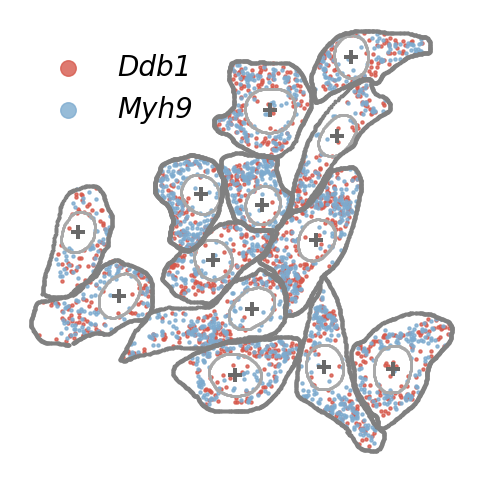

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), gridspec_kw={'hspace': 0., 'wspace': 0.01})

gene1 ='Ddb1'
seqfish_data_i_gene1 = seqfish_data_i[seqfish_data_i.gene == gene1]

gene2 ='Myh9'
seqfish_data_i_gene2 = seqfish_data_i[seqfish_data_i.gene == gene2]


ax.scatter(seqfish_data_i_gene1['x'], seqfish_data_i_gene1['y'], label=gene1, alpha=0.8, s=5,color='#d6594c')
ax.scatter(seqfish_data_i_gene2['x'], seqfish_data_i_gene2['y'], label=gene2, alpha=0.8, s=5,color='#7dabcf')
ax.scatter(nuclear_mask_contour_i['x'], nuclear_mask_contour_i['y'], alpha=0.6, s=1,color='darkgrey')

ax.scatter(cell_mask_contour_i['x'], cell_mask_contour_i['y'], color='grey', s=3)
ax.scatter(cell_mask_contour_i['centerX'], cell_mask_contour_i['centerY'], marker='+', color='dimgray', s=100)
ax.axis('off')
leg = ax.legend(fontsize=20,markerscale=5,bbox_to_anchor=(0.45, 0.7),frameon=False)
for t in leg.get_texts():     
    t.set_fontstyle('italic')

ax.set_aspect('equal')
# plt.savefig(f'{data_path}/output/seqfish/figures/gene_colocalization_examples_batch{batch}_pair_1.png', dpi=300, bbox_inches='tight',transparent=True)
plt.show()

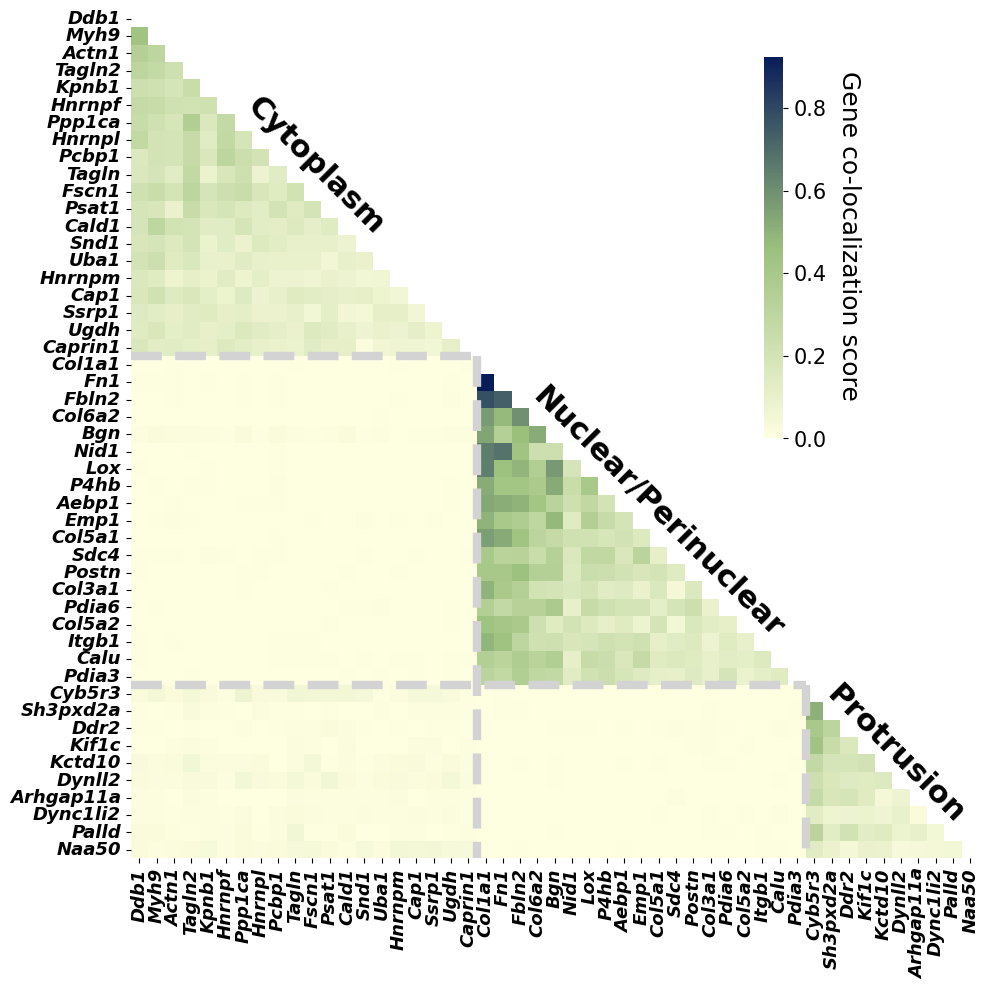

In [ ]:

custom_cmap = create_color_cmap('#FEFEE1','#9bc07c','#081D58', name='white_to_red')

fig, ax = plt.subplots(figsize=(15, 10))#YlGnBu

mask = np.triu(np.ones_like(gene_similarity_sym, dtype=bool))
gene_interested_capitalized = [gene for gene in gene_interested]
heatmap = sns.heatmap(gene_similarity_sym, cmap=custom_cmap,xticklabels=gene_interested_capitalized, yticklabels=gene_interested_capitalized,mask=mask, cbar_kws={'shrink': 0.45,'pad':-0.05,'anchor':(-0.7,0.9),"location":"right"}, # 调整颜色条大小 mask=mask,#
                   square=True) 
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontweight='bold',fontsize=13,fontstyle='italic')
heatmap.set_yticklabels(heatmap.get_xticklabels(), fontweight='bold',fontsize=13,fontstyle='italic')

cbar = heatmap.collections[0].colorbar
cbar.ax.set_position([1, 0.1, 0.9, 0.2])

cbar.ax.tick_params(labelsize=15)
cbar.set_label('Gene co-localization score', rotation=270, fontsize=18,loc='top',labelpad=25)##,fontweight='bold' proportion of cells in which the gene pair is considered as the 10 nearest neighbors
cbar_ax = cbar.ax
text_obj = cbar_ax.get_yaxis().get_label()

text_obj.set_position((-0.3, 0.1))
ax.plot([0, 20], [20, 20], color='lightgray', linestyle='--',linewidth=6)
ax.plot([0, 39], [39, 39], color='lightgray', linestyle='--',linewidth=6)
ax.plot([20, 20], [20, 49], color='lightgray', linestyle='--',linewidth=6)
ax.plot([39, 39], [39, 49], color='lightgray', linestyle='--',linewidth=6)

y_bottom=0
ax.text(15, y_bottom+9, 'Cytoplasm', va='center', ha='right', color='black', fontsize=22, fontweight='bold',rotation=315)
ax.text(38, y_bottom+29, 'Nuclear/Perinuclear', va='center', ha='right', color='black', fontsize=22, fontweight='bold',rotation=315)
ax.text(48.5, y_bottom+43, 'Protrusion', va='center', ha='right', color='black', fontsize=22, fontweight='bold',rotation=315)

plt.tight_layout()
fig.savefig(f"{data_path}output/seqfish/figures/gene_colocalization_49.png",
            transparent=True,     
            dpi=300,
            bbox_inches="tight")   
plt.show()

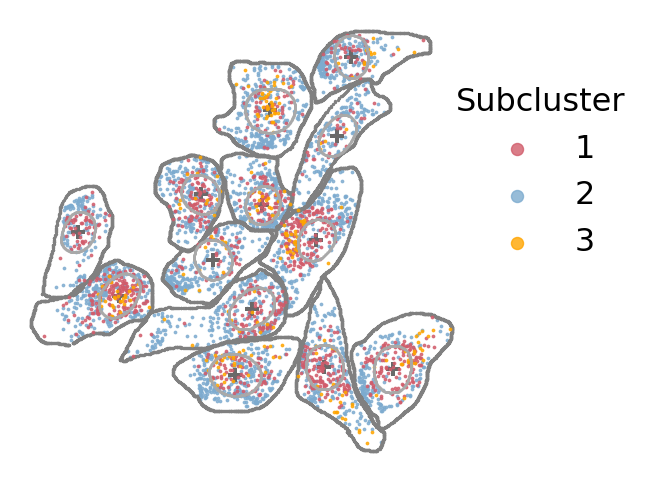

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), gridspec_kw={'hspace': 0., 'wspace': 0.01})


seqfish_data_i_nuclearSub1 = seqfish_data_i[seqfish_data_i.gene.isin(nuclearSub1List)]
seqfish_data_i_nuclearSub2 = seqfish_data_i[seqfish_data_i.gene.isin(nuclearSub2List)]
seqfish_data_i_nuclearSub3 = seqfish_data_i[seqfish_data_i.gene.isin(nuclearSub3List)]

ax.scatter(seqfish_data_i_nuclearSub1['x'], seqfish_data_i_nuclearSub1['y'], label='1', alpha=0.8, s=3,color='#d15c6b',zorder=10)
ax.scatter(seqfish_data_i_nuclearSub2['x'], seqfish_data_i_nuclearSub2['y'], label='2', alpha=0.8, s=3,color='#7dabcf')
ax.scatter(seqfish_data_i_nuclearSub3['x'], seqfish_data_i_nuclearSub3['y'], label='3', alpha=0.8, s=3,color='orange',zorder=20)
ax.scatter(nuclear_mask_contour_i['x'], nuclear_mask_contour_i['y'], alpha=0.6, s=0.5,color='darkgrey',zorder=30)

ax.scatter(cell_mask_contour_i['x'], cell_mask_contour_i['y'], color='grey', s=2)
ax.scatter(cell_mask_contour_i['centerX'], cell_mask_contour_i['centerY'], marker='+', color='dimgray', s=100)
ax.axis('off')
ax.legend( fontsize=23,markerscale=5,bbox_to_anchor=(0.9, 0.4),frameon=False,title='Subcluster',title_fontsize=23)
ax.set_aspect('equal')

plt.show()

In [32]:
train_count_sum = train_image.sum(axis=(2,3))
# Compute pairwise distances between gene embeddings for each cell
num_cells, num_genes, embedding_dim = latent_np.shape
gene_interested = [gene for gene in nuclearSub1List + nuclearSub2List + nuclearSub3List]
print("gene_interested:",len(gene_interested),gene_interested)
gene_idx = [gene_names.index(i)  for i in gene_interested]
latent_np_interested = latent_np[:, gene_idx]
most_similar_genes_all_cells = {gene: [] for gene in gene_interested}
### calculate the count of cells which consider gene A as the 10 nearest neighbors in embedding space of gene B
gene_similarity = np.zeros((len(gene_interested), len(gene_interested)))
for cell in tqdm(range(num_cells)):
    gene_similarity_i = np.zeros((len(gene_interested), len(gene_interested)))
    # Compute pairwise distances for the current cell
    distances = cdist(latent_np_interested[cell], latent_np[cell], metric='cosine')
    
    # Identify the most similar genes for each gene of interest in the current cell
    idx = 0 
    for gene in gene_interested:
        if train_count_sum[cell][gene_idx][idx]!=0:
            most_similar_genes = np.argsort(distances[idx])[1:11]  # Exclude self-distance
            for j in most_similar_genes:
                if gene_names[j] in gene_interested:
                    gene_similarity_i[gene_interested.index(gene), gene_interested.index(gene_names[j])] = 1
        idx += 1
    gene_similarity += gene_similarity_i

gene_similarity = gene_similarity/ ((train_count_sum!=0).sum(axis=0)[gene_idx]).reshape(-1,1).repeat(len(gene_interested), axis=1)

gene_interested: 11 ['Thbs1', 'Serpine1', 'Ptx3', 'Tnc', 'Flna', 'Flnb', 'Plec', 'Flnc', 'Iqgap1', 'Numa1', 'Gorasp2']


  0%|          | 0/157 [00:00<?, ?it/s]

100%|██████████| 157/157 [00:00<00:00, 540.54it/s]


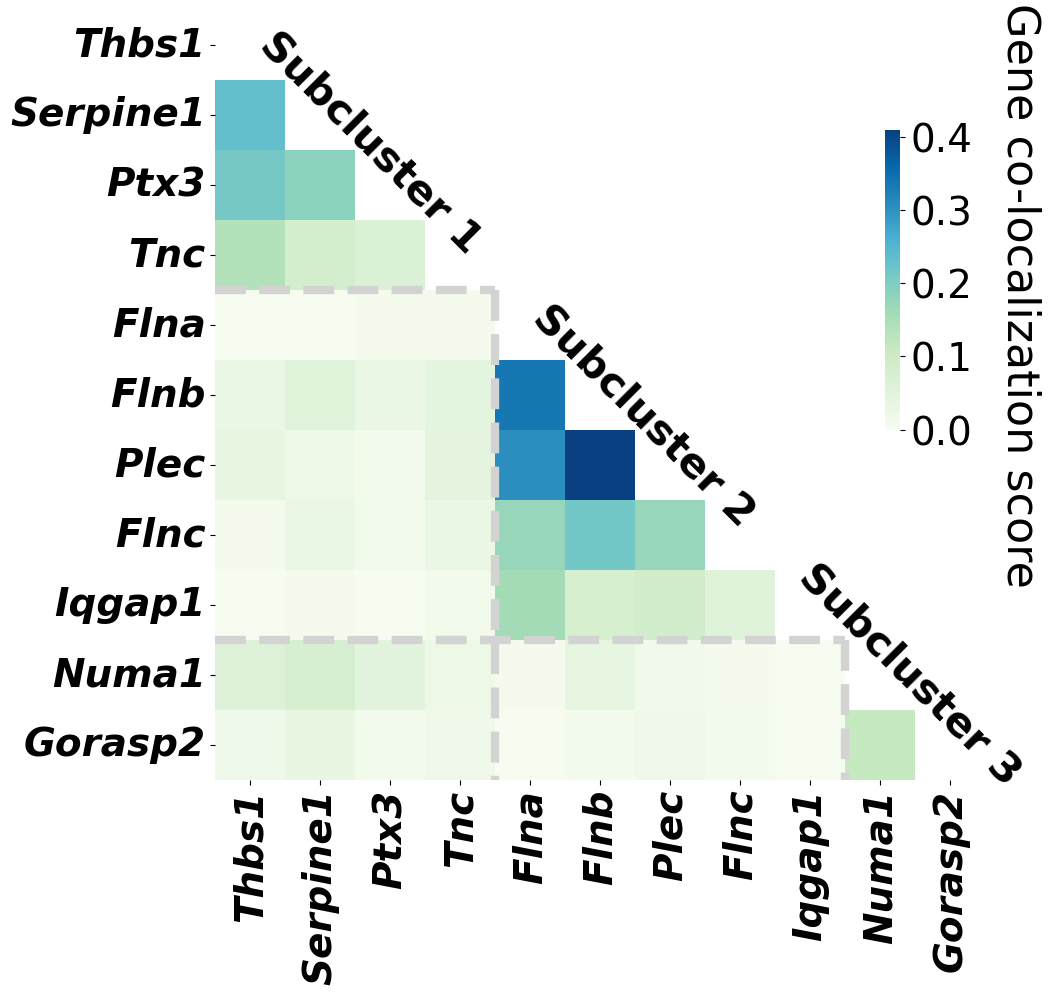

: 

In [ ]:
gene_similarity_sym =  np.maximum(gene_similarity, gene_similarity.T)
gene_interested_capitalize = [gene.capitalize() for gene in gene_interested]
fig, ax = plt.subplots(figsize=(10, 10))

mask = np.triu(np.ones_like(gene_similarity_sym, dtype=bool))

heatmap = sns.heatmap(gene_similarity_sym, cmap='GnBu',xticklabels=gene_interested_capitalize, yticklabels=gene_interested_capitalize,mask=mask, cbar_kws={'shrink': 0.95,'pad':-0.15,'anchor':(0,0.7),'ticks':[0,0.1,0.2,0.3,0.4]}, 
                   square=True)  
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontweight='bold',fontsize=28,rotation=90,fontstyle='italic')
heatmap.set_yticklabels(heatmap.get_xticklabels(), fontweight='bold',fontsize=28,rotation=0,fontstyle='italic')

cbar = heatmap.collections[0].colorbar
cbar.ax.set_position([0.8, 0.46, 0.9, 0.3])

cbar.ax.tick_params(labelsize=28)

cbar.set_label("Gene co-localization score", rotation=270, fontsize=32,labelpad=50)
cbar_ax = cbar.ax
text_obj = cbar_ax.get_yaxis().get_label()

text_obj.set_position((0.9, 0.45))

ax.plot([0, 4], [4, 4], color='lightgray', linestyle='--',linewidth=6)
ax.plot([0, 9], [9, 9], color='lightgray', linestyle='--',linewidth=6)
ax.plot([4, 4], [4, 11], color='lightgray', linestyle='--',linewidth=6)
ax.plot([9, 9], [9, 11], color='lightgray', linestyle='--',linewidth=6)

y_bottom=0
ax.text(3.9, y_bottom+1.9, 'Subcluster 1', va='center', ha='right', color='black', fontsize=30, fontweight='bold',rotation=315)
ax.text(7.8, y_bottom+5.8, 'Subcluster 2', va='center', ha='right', color='black', fontsize=30, fontweight='bold',rotation=315)
ax.text(11.6, y_bottom+9.5, 'Subcluster 3', va='center', ha='right', color='black', fontsize=30, fontweight='bold',rotation=315)


plt.show()